In [14]:
from glob import glob
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import models
from tqdm.auto import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import logging

# Logging setup
logging.basicConfig(filename="model_info_resnet50.log", format='%(asctime)s %(message)s', filemode='w')
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
DATA_DIR = "/home/prateek/Projects/Classification models/seg_train/seg_train"
num_classes = 6

# Configurations
CONFIG = dict(
    epochs=5,
    max_lr=3e-5,
    pct_start=0.2,
    anneal_strategy='linear',
    weight_decay=0.0002,
    batch_size=32,
    dropout=0.5,
    hid_dim=512,
    activation='relu'
)

# Activation functions
class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)

get_activation = {
    'q_gelu': QuickGELU,
    'relu': nn.ReLU,
    'elu': nn.ELU,
    'leaky_relu': nn.LeakyReLU
}

# Helper class to track metrics
class AverageMeter:
    def __init__(self, name=None):
        self.name = name
        self.reset()

    def reset(self):
        self.sum = self.count = self.avg = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Dataset class
class ImageDataset(Dataset):
    def __init__(self, root_dir, augment=False):
        self.im_paths = glob(os.path.join(root_dir, "*", "*"))
        self.augment = augment

        self.transform = A.Compose([
    A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    A.Rotate(limit=30, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])


        self.val_transform = A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

        self.classes = sorted({os.path.basename(os.path.dirname(p)) for p in self.im_paths})
        self.label_dict = {name: idx for idx, name in enumerate(self.classes)}
        logger.info(f"Label mapping: {self.label_dict}")

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        folder_name = os.path.basename(os.path.dirname(im_path))
        label = self.label_dict[folder_name]

        img = cv2.imread(im_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.augment:
            img = self.transform(image=img)['image']
        else:
            img = self.val_transform(image=img)['image']

        return img, label

# Loaders

def load_split_train_test(datadir, valid_size=0.2, augment=True):
    dataset = ImageDataset(datadir, augment=augment)
    indices = list(range(len(dataset)))
    np.random.shuffle(indices)

    split = int(np.floor(valid_size * len(dataset)))
    train_idx, test_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    trainloader = DataLoader(dataset, sampler=train_sampler, batch_size=CONFIG['batch_size'],
                             pin_memory=True, drop_last=True, num_workers=4)
    testloader = DataLoader(dataset, sampler=test_sampler, batch_size=CONFIG['batch_size'],
                            pin_memory=True, drop_last=False, num_workers=4)
    return trainloader, testloader

# ResNet50 classifier
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.base_model = models.resnet50(pretrained=True)

        for param in self.base_model.parameters():
            param.requires_grad = False

        for param in list(self.base_model.layer4.parameters()):
            param.requires_grad = True

        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features, CONFIG['hid_dim']),
            get_activation[CONFIG['activation']](),
            nn.Dropout(CONFIG['dropout']),
            nn.Linear(CONFIG['hid_dim'], CONFIG['hid_dim'] // 2),
            get_activation[CONFIG['activation']](),
            nn.Dropout(CONFIG['dropout']),
            nn.Linear(CONFIG['hid_dim'] // 2, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

# Train and validate
trainloader, testloader = load_split_train_test(DATA_DIR)
model = ResNet50Classifier(num_classes=num_classes)
model = nn.DataParallel(model)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CONFIG["max_lr"], weight_decay=CONFIG["weight_decay"])
global_accuracy = 0.0
train_losses = []
val_losses = []# Training loop
for epoch in range(1, CONFIG["epochs"] + 1):
    model.train()
    losses = AverageMeter()

    with tqdm(total=len(trainloader), desc=f"Epoch {epoch}/{CONFIG['epochs']}") as pbar:
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            loss = criterion(preds, labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            losses.update(loss.item(), images.size(0))
            pbar.update(1)

    # Validation
    model.eval()
    correct, total = 0, 0
    test_losses = AverageMeter()
    

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            loss = criterion(preds, labels)
            correct += (preds.argmax(1) == labels).sum().item()
            total += labels.size(0)
            test_losses.update(loss.item(), images.size(0))
    train_losses.append(losses.avg)
    val_losses.append(test_losses.avg)

    accuracy = correct / total
    print(f"Epoch {epoch}: Train Loss={losses.avg:.4f}, Test Loss={test_losses.avg:.4f}, Accuracy={accuracy:.4f}")

    # Save weights
    save_dir = 'resnet50_weights'
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(save_dir, f'epoch_{epoch:03d}.pth'))

    if accuracy > global_accuracy:
        global_accuracy = accuracy
        torch.save(model.state_dict(), os.path.join(save_dir, 'best.pth'))

    torch.save(model.state_dict(), os.path.join(save_dir, 'latest.pth'))

/home/prateek/miniconda3/envs/nenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/prateek/miniconda3/envs/nenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5: 100%|██████████| 350/350 [00:49<00:00,  7.12it/s]


Epoch 1: Train Loss=0.7729, Test Loss=0.2742, Accuracy=0.9081


Epoch 2/5: 100%|██████████| 350/350 [00:48<00:00,  7.17it/s]


Epoch 2: Train Loss=0.3217, Test Loss=0.2450, Accuracy=0.9134


Epoch 3/5: 100%|██████████| 350/350 [00:48<00:00,  7.17it/s]


Epoch 3: Train Loss=0.2941, Test Loss=0.2233, Accuracy=0.9216


Epoch 4/5: 100%|██████████| 350/350 [00:48<00:00,  7.17it/s]


Epoch 4: Train Loss=0.2486, Test Loss=0.2046, Accuracy=0.9273


Epoch 5/5: 100%|██████████| 350/350 [00:48<00:00,  7.15it/s]


Epoch 5: Train Loss=0.2211, Test Loss=0.2191, Accuracy=0.9266


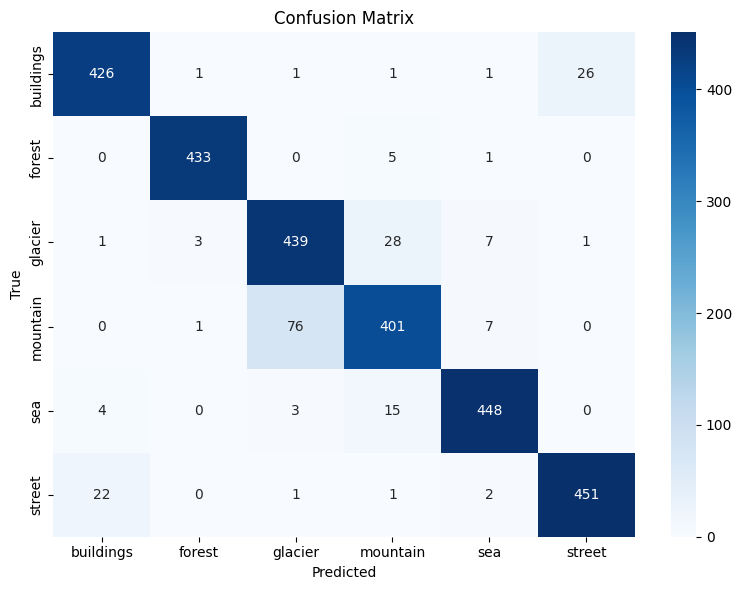

In [20]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Your class names
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Function to get predictions and true labels from model and dataloader
def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Assume you have your model and testloader defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
preds, labels = get_predictions(model, testloader, device)

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [29]:
import torch
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import models
import torch.nn as nn

# Config & activation (same as training)
CONFIG = dict(dropout=0.5, hid_dim=512, activation='relu')

class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)

get_activation = {
    'q_gelu': QuickGELU,
    'relu': nn.ReLU,
    'elu': nn.ELU,
    'leaky_relu': nn.LeakyReLU
}

# Model definition
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.base_model = models.resnet50(pretrained=True)
        for param in self.base_model.parameters():
            param.requires_grad = False
        for param in list(self.base_model.layer4.parameters()):
            param.requires_grad = True
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features, CONFIG['hid_dim']),
            get_activation[CONFIG['activation']](),
            nn.Dropout(CONFIG['dropout']),
            nn.Linear(CONFIG['hid_dim'], CONFIG['hid_dim'] // 2),
            get_activation[CONFIG['activation']](),
            nn.Dropout(CONFIG['dropout']),
            nn.Linear(CONFIG['hid_dim'] // 2, num_classes)
        )
    def forward(self, x):
        return self.base_model(x)

# Class names must match training
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Validation transform (same as training)
val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

def predict_image(model, image_path, device):
    model.eval()
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = val_transform(image=img)['image'].unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img_tensor)
        _, pred_idx = torch.max(outputs, 1)
    return class_names[pred_idx.item()]

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ResNet50Classifier(num_classes=len(class_names))
    model = nn.DataParallel(model)
    model.load_state_dict(torch.load("resnet50_weights/best.pth"))  # update path as needed
    model = model.to(device)

    image_path = "seg_pred/seg_pred/24327.jpg"  # update this path
    predicted_class = predict_image(model, image_path, device)
    print(f"Predicted class: {predicted_class}")


Predicted class: glacier


In [30]:
import torch.nn.functional as F

def predict_image_with_confidence(model, image_path, device):
    model.eval()
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = val_transform(image=img)['image'].unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = F.softmax(outputs, dim=1)
        conf, pred_idx = torch.max(probs, 1)
    return class_names[pred_idx.item()], conf.item()


In [31]:
predicted_class, confidence = predict_image_with_confidence(model, image_path, device)
print(f"Predicted class: {predicted_class} with confidence: {confidence:.4f}")


Predicted class: glacier with confidence: 0.9478
